In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from  sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

label_encoder = LabelEncoder()
import matplotlib.pyplot as plt

InputLayer = keras.layers.InputLayer()
LSTM = keras.layers.LSTM
Dropout = keras.layers.Dropout
Dense = keras.layers.Dense

In [3]:
df = pd.read_csv('/Users/victoroliveira/Desktop/vonix-py-statistic/src/vonixstatisc/data/pandas_data/data_fluency_queue_no_auto_dialer.csv')

df_to_dict = pd.DataFrame()

df = df.loc[df['queue_id'] == 'mgmsales']
df = df.loc[(df['handling_time'] > 10) & (df['handling_time'] < 200) ]
df = df.loc[df['agent_id'] == 1592]
df = df.loc[df['week_day'] == 2]
df= df.dropna(axis=0)

df

,agent_id,queue_id,direction,locality_id,call_type_id,hold_secs,ring_secs,initial_position,trunking_id,carrier_id,week_day,day,month,hour,minute,timestamp,handling_time
19529,1592,mgmsales,OUT,21.0,5,0,9,0,1,67.0,2,7,March,17,3,1678209768,103
19629,1592,mgmsales,OUT,42.0,4,0,20,0,1,3.0,2,7,March,18,3,1678212370,12
19642,1592,mgmsales,OUT,41.0,8,0,24,0,1,3.0,2,7,March,18,3,1678212724,73
19699,1592,mgmsales,OUT,91.0,5,0,15,0,1,1.0,2,7,March,18,3,1678213956,14
19812,1592,mgmsales,OUT,41.0,8,0,10,0,1,3.0,2,7,March,19,3,1678216028,11
19893,1592,mgmsales,OUT,48.0,4,0,12,0,1,1.0,2,7,March,19,3,1678217100,154
19926,1592,mgmsales,OUT,92.0,5,0,21,0,1,5.0,2,7,March,19,3,1678217635,75
20190,1592,mgmsales,OUT,92.0,5,0,51,0,1,67.0,2,7,March,20,3,1678221131,18
20351,1592,mgmsales,OUT,11.0,5,0,4,0,1,3.0,2,7,March,21,3,1678223660,53
20524,1592,mgmsales,OUT,61.0,5,0,12,0,1,67.0,2,7,March,21,3,1678225499,99


In [4]:
df_to_dict['time'] = df['timestamp']
df_to_dict['ht'] = df['handling_time']

In [5]:
dict = df_to_dict.set_index('time').to_dict()['ht']
#dict

In [28]:
from datetime import datetime
from time import gmtime, strftime
import time
def transform_dict(data: dict, period: int) -> dict:
    """method that receives dict from database query
    {start_at(timestamp): talk_secs(seconds), ...} and create
    another dict based on the period (15, 30, 1hr) chosen
    {last_timestamp: [12,24,56,12, 90, 100], last_timestamp - period:[195,235,201,300], ... interval of three minutes for standard model}
    For standard model the data from the last period( 15 min, 30 min, 1h) is used to construct forecast for the next period so the return_dict begins with the last timestamp to the first
    """
    seconds = period * 60
    
    return_dict = {}

    keys_array = list(data.keys())
    beginning = keys_array[0]
    limit= beginning + seconds
    end = keys_array[-1]
    arr = []
    break_v = 1
    indice = 0
    while beginning < end:
        if break_v == beginning:
            break
        break_v = beginning
        for key, value in data.items():
            if key <= limit:
                arr.append(value)
                continue
        
            return_dict[f"{indice}"] = arr
            indice += 1
            arr = []
            arr.append(value)
            beginning = key
            limit = beginning + seconds
            

    return return_dict

In [29]:
dict_transformed = transform_dict(dict,120)

In [30]:
#dict_transformed

In [31]:
mean_object = {i: np.mean(dict_transformed[i]) for i in dict_transformed.keys()}

In [32]:
#mean_object

In [33]:
cv_object = {i: np.std(dict_transformed[i]) for i in dict_transformed.keys()}

In [12]:
#cv_object

In [13]:
call_volume = {i: len(dict_transformed[i]) for i in dict_transformed.keys()}

In [14]:
#call_volume

In [15]:
df_to_ml = pd.DataFrame()
df_to_ml['call_volume'] = call_volume.values()
df_to_ml['cv'] = cv_object.values()
df_to_ml['mean'] = mean_object.values()
df_to_ml

,call_volume,cv,mean
0,5,38.275841,42.600000
1,4,49.934958,75.000000
2,1,0.000000,99.000000
3,6,13.438130,63.500000
4,10,27.636932,44.000000
5,1,0.000000,80.000000
6,3,10.780641,86.666667
7,3,4.496913,36.333333
8,5,59.466293,52.600000


In [16]:
df_to_ml.iloc[:, 0:3].values
x_train = df_to_ml.iloc[:, 0:3].values[:, 2:3]
#x_train

In [17]:
normalizador = MinMaxScaler(feature_range = (0,1))
base = normalizador.fit_transform(df_to_ml.iloc[:, 0:3].values)
base.shape

(9, 3)

In [18]:
previsores = []
tempo_real = []


In [19]:
for i in range(1, 9):
    previsores.append(base[i-1:i, 0:3])
    tempo_real.append(base[i,2])

In [20]:
previsores

[array([[0.44444444, 0.64365608, 0.1       ]]),
 array([[0.33333333, 0.83971869, 0.61702128]]),
 array([[0., 0., 1.]]),
 array([[0.55555556, 0.22597894, 0.43351064]]),
 array([[1.        , 0.46474953, 0.12234043]]),
 array([[0.        , 0.        , 0.69680851]]),
 array([[0.22222222, 0.18128995, 0.80319149]]),
 array([[0.22222222, 0.0756212 , 0.        ]])]

In [21]:
previsores, tempo_real = np.array(previsores), np.array(tempo_real)
previsores= np.reshape(previsores, (previsores.shape[0], previsores.shape[1],3))

In [22]:
previsores.shape[0:]

(8, 1, 3)

In [23]:
tempo_real.shape[0]

8

In [24]:
from keras.optimizers import SGD
opt = SGD(learning_rate=0.01, momentum=0.9)
regressor = keras.models.Sequential()
#camadas inicial
regressor.add(LSTM(units = 100, return_sequences = True, input_shape=(1,3)))
regressor.add(Dropout(0.3))     

#camadas
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))    

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))  

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3)) 

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3)) 
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3)) 
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3)) 
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3)) 
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3)) 

#camadas finais
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3)) 

regressor.add(Dense(units = 1, activation = 'sigmoid'))
 
regressor.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])



In [25]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [26]:
es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10 , verbose =1)
rlr = ReduceLROnPlateau(monitor = 'loss', factoe = 0.2, patience = 5, verbose = 1)
mcp = ModelCheckpoint(filepath = 'pesos.h5', monitor = 'loss', save_best_only = True)

In [27]:
regressor.fit(previsores, tempo_real, epochs = 100, batch_size = 51, callbacks = [es, rlr, mcp])

Epoch 1/100


2023-05-04 11:04:54.242295: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 4s 4s/step - loss: 0.6931 - accuracy: 0.1250 - lr: 0.0100
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.1250 - lr: 0.0100
Epoch 3/100
1/1 [==============================] - 0s 25ms/step - loss: 0.6931 - accuracy: 0.1250 - lr: 0.0100
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.1250 - lr: 0.0100
Epoch 5/100
1/1 [==============================] - 0s 24ms/step - loss: 0.6931 - accuracy: 0.1250 - lr: 0.0100
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.1250
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
1/1 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.1250 - lr: 0.0100
Epoch 7/100
1/1 [==============================] - 0s 24ms/step - loss: 0.6931 - accuracy: 0.1250 - lr: 1.0000e-03
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6931 -

In [192]:
data_to_predict = pd.read_csv('/Users/victoroliveira/Desktop/vonix-py-statistic/jupyter-studies/nn_models/nn_onequeue_allTimes/test_data.csv')
data_to_predict = data_to_predict.iloc[:, 0:3].values
y_real = data_to_predict[:, 2:3]

#results_real
#data_to_predict
normalizador_pred = MinMaxScaler(feature_range = (0,1))
normalizador_pred.fit_transform(data_to_predict[:,2:3])
data_predict = []
data_predict_normalizada = normalizador.transform(data_to_predict)
#data_to_predict
data_predict_normalizada.shape


(17, 3)

In [193]:
for i in range(1, 17):
    data_predict.append(data_predict_normalizada[i-1:i, 0:3])
data_predict = np.array(data_predict)
data_predict= np.reshape(data_predict, (data_predict.shape[0], data_predict.shape[1],3)) # to help to know the shape
data_predict.shape

(16, 1, 3)

In [194]:
y_real

array([[ 54.        ],
       [129.        ],
       [ 18.        ],
       [ 45.5       ],
       [ 74.        ],
       [ 74.        ],
       [ 77.        ],
       [ 38.66666667],
       [ 20.        ],
       [184.        ],
       [195.        ],
       [ 38.        ],
       [ 74.        ],
       [ 83.        ],
       [ 95.        ],
       [ 71.        ],
       [ 70.        ]])

In [195]:
results_real = regressor.predict(data_predict)

y_test = normalizador_pred.inverse_transform(results_real)
y_test

1/1 [==============================] - 0s 335ms/step


array([[112.34476],
       [112.34474],
       [112.34476],
       [112.34476],
       [112.34476],
       [112.34476],
       [112.34475],
       [112.34476],
       [112.34476],
       [112.34474],
       [112.34474],
       [112.34476],
       [112.34476],
       [112.34475],
       [112.34474],
       [112.34476]], dtype=float32)

In [196]:
results_real

array([[0.5330212 ],
       [0.5330211 ],
       [0.5330212 ],
       [0.5330212 ],
       [0.5330212 ],
       [0.5330212 ],
       [0.53302115],
       [0.5330212 ],
       [0.5330212 ],
       [0.5330211 ],
       [0.5330211 ],
       [0.5330212 ],
       [0.5330212 ],
       [0.53302115],
       [0.5330211 ],
       [0.5330212 ]], dtype=float32)

In [197]:
y_real

array([[ 54.        ],
       [129.        ],
       [ 18.        ],
       [ 45.5       ],
       [ 74.        ],
       [ 74.        ],
       [ 77.        ],
       [ 38.66666667],
       [ 20.        ],
       [184.        ],
       [195.        ],
       [ 38.        ],
       [ 74.        ],
       [ 83.        ],
       [ 95.        ],
       [ 71.        ],
       [ 70.        ]])

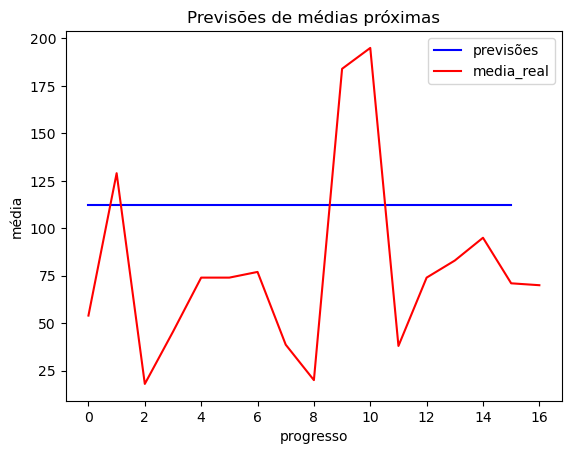

In [198]:
plt.plot(y_test, color = 'blue', label = 'previsões')
plt.plot(y_real, color = 'red', label = 'media_real')
plt.title('Previsões de médias próximas')
plt.xlabel('progresso')
plt.ylabel('média')
plt.legend()
plt.show()

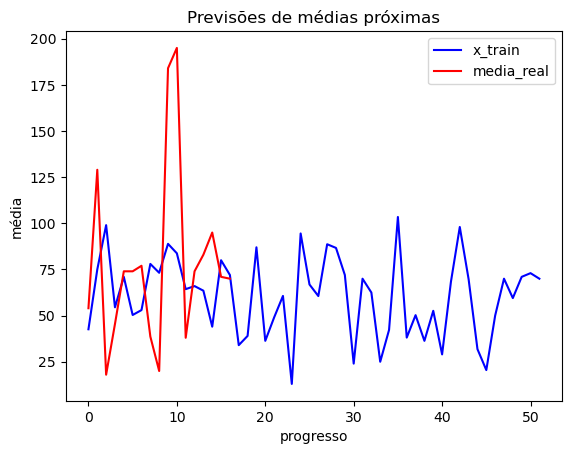

In [199]:
plt.plot(x_train, color = 'blue', label = 'x_train')
plt.plot(y_real, color = 'red', label = 'media_real')
plt.title('Previsões de médias próximas')
plt.xlabel('progresso')
plt.ylabel('média')
plt.legend()
plt.show()

In [34]:
x_train

array([[42.6       ],
       [75.        ],
       [99.        ],
       [63.5       ],
       [44.        ],
       [80.        ],
       [86.66666667],
       [36.33333333],
       [52.6       ]])